In [5]:
import pandas as pd
import numpy as np

# Ruta a los archivos

# ENERO

ruta_eno= "E:\\Downloads\\datos_geih_2024\\Ene_2024\\CSV\\Ocupados.CSV"
ruta_enotfdt= "E:\\Downloads\\datos_geih_2024\\Ene_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_encgsse= "E:\\Downloads\\datos_geih_2024\\Ene_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_endhv= "E:\\Downloads\\datos_geih_2024\\Ene_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_enm= "E:\\Downloads\\datos_geih_2024\\Ene_2024\\CSV\\Migración.CSV"
ruta_enoi= "E:\\Downloads\\datos_geih_2024\\Ene_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

enero_ocupados= pd.read_csv(ruta_eno, sep=";", encoding='latin1',low_memory=False)
enero_otras_formas_de_trabajo= pd.read_csv(ruta_enotfdt, sep=";", encoding='latin1',low_memory=False)
enero_caracteristicas_generales= pd.read_csv(ruta_encgsse, sep=";", encoding='latin1',low_memory=False)
enero_datos_del_hogar= pd.read_csv(ruta_endhv, sep=";", encoding='latin1',low_memory=False)
enero_migracion= pd.read_csv(ruta_enm, sep=";", encoding='latin1',low_memory=False)
enero_otros_ingresos_e_impuestos= pd.read_csv(ruta_enoi, sep=";", encoding='latin1', low_memory=False)

In [6]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
enero_otras_formas_de_trabajo = limpiar(enero_otras_formas_de_trabajo)
enero_caracteristicas_generales = limpiar(enero_caracteristicas_generales)
enero_migracion = limpiar(enero_migracion)
enero_otros_ingresos_e_impuestos = limpiar(enero_otros_ingresos_e_impuestos)


In [7]:
df_merged1 = enero_ocupados.merge(enero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged1 = df_merged1.merge(enero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged1 = df_merged1.merge(enero_migracion, on=columnas_clave, how='left')
df_merged1 = df_merged1.merge(enero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')


In [8]:
df_merged1.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240101,1,2024,7655976,1,2,1,60,5.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240101,1,2024,7655977,1,1,1,60,5.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240101,1,2024,7655977,1,2,1,60,5.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [9]:
df_merged1.shape  # Número de filas y columnas
df_merged1.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28815 entries, 0 to 28814
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 95.2+ MB


In [10]:
df_merged1.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.881500e+04,28815.0,28815.0,2.881500e+04,28815.000000,28815.000000,28815.000000,28815.0,21212.000000,28815.000000,...,4.239000e+03,28815.000000,2.299000e+03,28815.000000,8.880000e+02,888.000000,888.000000,8.880000e+02,28815.000000,4.800000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024010e+07,1.0,2024.0,7.670712e+06,1.009509,1.803991,1.009509,60.0,41.405902,1.122193,...,2.211578e+04,1.930418,5.017920e+05,1.992261,1.748075e+06,1.010135,2022.166667,1.659960e+06,2.008537,3.473816e+06
std,1.167783e+00,0.0,0.0,8.552765e+03,0.114445,1.170377,0.114445,0.0,27.077398,0.327515,...,2.446687e+05,0.382583,8.612194e+05,0.438534,7.237603e+06,0.192617,0.390608,7.195505e+06,0.270216,7.385296e+06
min,2.024010e+07,1.0,2024.0,7.655976e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2020.000000,0.000000e+00,1.000000,9.800000e+01
25%,2.024010e+07,1.0,2024.0,7.663394e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.000000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,9.024750e+03
50%,2.024010e+07,1.0,2024.0,7.670406e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.900000e+01,1.000000,2022.000000,9.800000e+01,2.000000,8.000000e+05
75%,2.024010e+07,1.0,2024.0,7.678428e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.000000e+05,2.000000,8.910000e+05,1.000000,2022.000000,7.575000e+05,2.000000,2.350000e+06


In [11]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged1.isnull().sum().sort_values(ascending=False)

P3374S3        28815
P6080S1A1      28815
P3096S2        28814
P3096S3        28814
P3096S1        28814
P7028S1        28814
P6780S1        28813
P3087S1        28812
P6430S1        28811
P3086S1        28811
P750S3         28808
P750S3A1       28808
P3088          28807
P6765S1        28807
P3086          28807
P3085          28807
P3084S2        28807
P3083S1        28807
P3087          28807
P3082S3A1      28805
P3082S3A2      28805
P3082S2A2      28800
P3082S2A1      28800
P3055S1        28799
P6915S1        28797
P6630S6A1      28796
P3081S3A2      28795
P3081S3A1      28795
P3079S3A1      28791
P3079S3A2      28791
P750S1A1       28788
P750S1         28788
P3091S2        28782
P3091S1        28782
P3374S2        28778
P3078S3A1      28768
P3078S3A2      28768
P3372S1        28767
P6585S4A1      28763
P6585S4A2      28763
P6880S1        28761
P3093S2        28760
P3093S1        28760
P3077S3A1      28755
P3077S3A2      28755
P3386S1        28753
P3076S3A1      28752
P3076S3A2    

FEBRERO

In [12]:
# Ruta a los archivos

ruta_febno= "E:\\Downloads\\datos_geih_2024\\Febrero_2024\\CSV\\Ocupados.CSV"
ruta_febnotfdt= "E:\\Downloads\\datos_geih_2024\\Febrero_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_febncgsse= "E:\\Downloads\\datos_geih_2024\\Febrero_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_febndhv= "E:\\Downloads\\datos_geih_2024\\Febrero_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_febnm= "E:\\Downloads\\datos_geih_2024\\Febrero_2024\\CSV\\Migración.CSV"
ruta_febnoi= "E:\\Downloads\\datos_geih_2024\\Febrero_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

febrero_ocupados = pd.read_csv(ruta_febno, sep=";", encoding='latin1', low_memory=False)
febrero_otras_formas_de_trabajo = pd.read_csv(ruta_febnotfdt, sep=";", encoding='latin1', low_memory=False)
febrero_caracteristicas_generales = pd.read_csv(ruta_febncgsse, sep=";", encoding='latin1', low_memory=False)
febrero_datos_del_hogar = pd.read_csv(ruta_febndhv, sep=";", encoding='latin1', low_memory=False)
febrero_migracion = pd.read_csv(ruta_febnm, sep=";", encoding='latin1', low_memory=False)
febrero_otros_ingresos_e_impuestos = pd.read_csv(ruta_febnoi, sep=";", encoding='latin1', low_memory=False)


In [13]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
febrero_otras_formas_de_trabajo = limpiar(febrero_otras_formas_de_trabajo)
febrero_caracteristicas_generales = limpiar(febrero_caracteristicas_generales)
febrero_migracion = limpiar(febrero_migracion)
febrero_otros_ingresos_e_impuestos = limpiar(febrero_otros_ingresos_e_impuestos)

In [14]:
df_merged2 = febrero_ocupados.merge(febrero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_migracion, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [15]:
df_merged2.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240205,2,2024,7685523,1,2,1,60,50.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240205,2,2024,7685524,1,1,1,60,50.0,1,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240205,2,2024,7685524,1,2,1,60,50.0,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [16]:
df_merged2.shape  # Número de filas y columnas
df_merged2.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29943 entries, 0 to 29942
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 98.9+ MB


In [17]:
df_merged2.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.994300e+04,29943.0,29943.0,2.994300e+04,29943.000000,29943.000000,29943.000000,29943.0,22105.000000,29943.000000,...,4.328000e+03,29943.000000,2.465000e+03,29943.000000,9.330000e+02,933.000000,933.000000,9.330000e+02,29943.000000,5.200000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024021e+07,2.0,2024.0,7.699516e+06,1.010954,1.799719,1.010954,60.0,41.636327,1.122366,...,9.164903e+04,1.926093,5.157285e+05,1.989413,2.000469e+06,1.007503,2022.209003,1.909982e+06,2.007614,2.477248e+06
std,1.513751e+00,0.0,0.0,8.181095e+03,0.131327,1.165572,0.131327,0.0,27.060275,0.327713,...,4.585622e+06,0.368480,9.225204e+05,0.418402,1.986853e+07,0.170040,0.757115,1.981361e+07,0.259111,7.475820e+06
min,2.024020e+07,2.0,2024.0,7.685523e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2003.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024021e+07,2.0,2024.0,7.692324e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.000000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,9.590000e+04
50%,2.024021e+07,2.0,2024.0,7.699406e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,2.980000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,6.250000e+05
75%,2.024021e+07,2.0,2024.0,7.706471e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.500000e+05,2.000000,6.000000e+05,1.000000,2022.000000,6.000000e+05,2.000000,1.575000e+06


In [18]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged2.isnull().sum().sort_values(ascending=False)

P6080S1A1      29943
P3374S3        29942
P3096S2        29942
P3096S3        29942
P6780S1        29942
P3096S1        29942
P3086S1        29941
P7028S1        29939
P3087S1        29938
P750S3         29936
P750S3A1       29936
P6430S1        29934
P6765S1        29933
P3086          29932
P3088          29932
P3087          29932
P3085          29932
P3083S1        29932
P3084S2        29932
P3082S3A1      29928
P3082S3A2      29928
P6915S1        29927
P6630S6A1      29926
P3081S3A2      29924
P3081S3A1      29924
P3055S1        29922
P750S1         29922
P750S1A1       29921
P3079S3A2      29916
P3079S3A1      29916
P3374S2        29909
P6880S1        29908
P3091S2        29904
P3091S1        29904
P3386S1        29896
P3082S2A1      29895
P3078S3A1      29895
P3078S3A2      29895
P3082S2A2      29895
P3089S2        29894
P3089S3        29894
P3089S1        29894
P3076S3A2      29891
P3076S3A1      29891
P3372S1        29891
P3077S3A1      29878
P3077S3A2      29878
P3093S1      

MARZO

In [19]:
ruta_maro= "E:\\Downloads\\datos_geih_2024\\Marzo_2024\\CSV\\Ocupados.CSV"
ruta_martfdt= "E:\\Downloads\\datos_geih_2024\\Marzo_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_marcgsse= "E:\\Downloads\\datos_geih_2024\\Marzo_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_mardhv= "E:\\Downloads\\datos_geih_2024\\Marzo_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_marm= "E:\\Downloads\\datos_geih_2024\\Marzo_2024\\CSV\\Migración.CSV"
ruta_maroi= "E:\\Downloads\\datos_geih_2024\\Marzo_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

marzo_ocupados= pd.read_csv(ruta_maro, sep=";", encoding='latin1',low_memory=False)
marzo_otras_formas_de_trabajo= pd.read_csv(ruta_martfdt, sep=";", encoding='latin1',low_memory=False)
marzo_caracteristicas_generales= pd.read_csv(ruta_marcgsse, sep=";", encoding='latin1',low_memory=False)
marzo_datos_del_hogar= pd.read_csv(ruta_mardhv, sep=";", encoding='latin1',low_memory=False)
marzo_migracion= pd.read_csv(ruta_marm, sep=";", encoding='latin1',low_memory=False)
marzo_otros_ingresos_e_impuestos= pd.read_csv(ruta_maroi, sep=";", encoding='latin1', low_memory=False)


In [20]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
marzo_otras_formas_de_trabajo = limpiar(marzo_otras_formas_de_trabajo)
marzo_caracteristicas_generales = limpiar(marzo_caracteristicas_generales)
marzo_migracion = limpiar(marzo_migracion)
marzo_otros_ingresos_e_impuestos = limpiar(marzo_otros_ingresos_e_impuestos)

In [21]:
df_merged3 = marzo_ocupados.merge(marzo_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged3 = df_merged3.merge(marzo_caracteristicas_generales, on=columnas_clave, how='left')
df_merged3 = df_merged3.merge(marzo_migracion, on=columnas_clave, how='left')
df_merged3 = df_merged3.merge(marzo_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [22]:
df_merged3.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240311,3,2024,7713749,1,1,1,60,NaN,1,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240311,3,2024,7713749,1,2,1,60,NaN,1,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240311,3,2024,7713749,1,4,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [23]:
df_merged3.shape  # Número de filas y columnas
df_merged3.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29638 entries, 0 to 29637
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 97.9+ MB


In [24]:
df_merged3.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.963800e+04,29638.0,29638.0,2.963800e+04,29638.000000,29638.000000,29638.000000,29638.0,21879.000000,29638.000000,...,4.432000e+03,29638.000000,2.439000e+03,29638.000000,9.210000e+02,921.0,921.000000,9.210000e+02,29638.000000,3.900000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024031e+07,3.0,2024.0,7.727791e+06,1.009684,1.779540,1.009684,60.0,41.605878,1.123591,...,1.271552e+05,1.927154,5.139469e+05,1.989237,1.475923e+06,1.0,2022.217155,1.317641e+06,2.003880,6.597938e+06
std,1.177197e+00,0.0,0.0,8.262889e+03,0.117075,1.130687,0.117075,0.0,27.135479,0.329120,...,7.347642e+06,0.378316,8.256906e+05,0.416110,6.383004e+06,0.0,0.476136,5.995335e+06,0.194099,3.183752e+07
min,2.024031e+07,3.0,2024.0,7.713749e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.0,2016.000000,0.000000e+00,1.000000,9.800000e+01
25%,2.024031e+07,3.0,2024.0,7.720718e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.080000e+05,2.000000,0.000000e+00,1.0,2022.000000,0.000000e+00,2.000000,3.050000e+05
50%,2.024031e+07,3.0,2024.0,7.727768e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.0,2022.000000,9.800000e+01,2.000000,9.000000e+05
75%,2.024031e+07,3.0,2024.0,7.735085e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.000000e+05,2.000000,6.500000e+05,1.0,2022.000000,5.500000e+05,2.000000,2.250000e+06


In [25]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged3.isnull().sum().sort_values(ascending=False)

P3374S3        29638
P6080S1A1      29638
P3096S3        29637
P3096S2        29637
P3096S1        29637
P6780S1        29636
P3086S1        29634
P3087S1        29633
P7028S1        29631
P750S3         29629
P750S3A1       29629
P3082S3A2      29626
P3082S3A1      29626
P6630S6A1      29625
P750S1         29624
P750S1A1       29624
P3081S3A1      29623
P3081S3A2      29623
P3055S1        29621
P3079S3A1      29620
P6430S1        29620
P3079S3A2      29620
P6765S1        29619
P6915S1        29618
P3087          29614
P3085          29614
P3083S1        29614
P3088          29614
P3084S2        29614
P3086          29614
P3386S1        29606
P3089S2        29600
P3089S1        29600
P3374S2        29600
P3089S3        29600
P3372S1        29599
P3091S2        29598
P3091S1        29598
P6880S1        29598
P3078S3A2      29593
P3078S3A1      29593
P3082S2A1      29586
P3082S2A2      29586
P3093S1        29585
P3093S2        29585
P6585S4A2      29583
P6585S4A1      29583
P3077S3A1    

ABRIL

In [26]:
ruta_abo= "E:\\Downloads\\datos_geih_2024\\Abril_2024\\CSV\\Ocupados.CSV"
ruta_abotfdt= "E:\\Downloads\\datos_geih_2024\\Abril_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_abcgsse= "E:\\Downloads\\datos_geih_2024\\Abril_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_abdhv= "E:\\Downloads\\datos_geih_2024\\Abril_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_abm= "E:\\Downloads\\datos_geih_2024\\Abril_2024\\CSV\\Migración.CSV"
ruta_aboi= "E:\\Downloads\\datos_geih_2024\\Abril_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

abril_ocupados= pd.read_csv(ruta_abo, sep=";", encoding='latin1',low_memory=False)
abril_otras_formas_de_trabajo= pd.read_csv(ruta_abotfdt, sep=";", encoding='latin1',low_memory=False)
abril_caracteristicas_generales= pd.read_csv(ruta_abcgsse, sep=";", encoding='latin1',low_memory=False)
abril_datos_del_hogar= pd.read_csv(ruta_abdhv, sep=";", encoding='latin1',low_memory=False)
abril_migracion= pd.read_csv(ruta_abm, sep=";", encoding='latin1',low_memory=False)
abril_otros_ingresos_e_impuestos= pd.read_csv(ruta_aboi, sep=";", encoding='latin1', low_memory=False)

In [27]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
abril_otras_formas_de_trabajo = limpiar(abril_otras_formas_de_trabajo)
abril_caracteristicas_generales = limpiar(abril_caracteristicas_generales)
abril_migracion = limpiar(abril_migracion)
abril_otros_ingresos_e_impuestos = limpiar(abril_otros_ingresos_e_impuestos)

In [28]:
df_merged4 = abril_ocupados.merge(enero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged4 = df_merged4.merge(abril_caracteristicas_generales, on=columnas_clave, how='left')
df_merged4 = df_merged4.merge(abril_migracion, on=columnas_clave, how='left')
df_merged4 = df_merged4.merge(abril_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [29]:
df_merged4.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240417,4,2024,7742093,1,1,1,60,NaN,1,...,98.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240417,4,2024,7742094,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240417,4,2024,7742095,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [30]:
df_merged4.shape  # Número de filas y columnas
df_merged4.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29741 entries, 0 to 29740
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(341), int64(69), object(23)
memory usage: 98.3+ MB


In [31]:
df_merged4.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.974100e+04,29741.0,29741.0,2.974100e+04,29741.000000,29741.000000,29741.000000,29741.0,21809.000000,29741.000000,...,4.497000e+03,29741.000000,2.550000e+03,29741.000000,9.720000e+02,972.000000,972.000000,9.720000e+02,29741.000000,5.900000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024042e+07,4.0,2024.0,7.756267e+06,1.007296,1.771427,1.007296,60.0,41.953872,1.122155,...,1.272727e+04,1.922733,5.872275e+05,1.985676,1.841047e+06,1.009259,2022.242798,1.477297e+06,2.007902,5.060779e+06
std,1.173885e+00,0.0,0.0,8.222169e+03,0.101006,1.110144,0.101006,0.0,27.106905,0.327470,...,1.371916e+05,0.372943,1.210949e+06,0.401238,1.115799e+07,0.131992,0.735099,5.732874e+06,0.266685,1.884051e+07
min,2.024041e+07,4.0,2024.0,7.742093e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2004.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024042e+07,4.0,2024.0,7.749259e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.100000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,2.000000e+04
50%,2.024042e+07,4.0,2024.0,7.756267e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.850000e+01,1.000000,2022.000000,9.800000e+01,2.000000,2.000000e+05
75%,2.024042e+07,4.0,2024.0,7.763424e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.000000e+05,2.000000,1.000000e+06,1.000000,2023.000000,8.000000e+05,2.000000,1.450000e+06


In [32]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged3.isnull().sum().sort_values(ascending=False)

P3374S3        29638
P6080S1A1      29638
P3096S3        29637
P3096S2        29637
P3096S1        29637
P6780S1        29636
P3086S1        29634
P3087S1        29633
P7028S1        29631
P750S3         29629
P750S3A1       29629
P3082S3A2      29626
P3082S3A1      29626
P6630S6A1      29625
P750S1         29624
P750S1A1       29624
P3081S3A1      29623
P3081S3A2      29623
P3055S1        29621
P3079S3A1      29620
P6430S1        29620
P3079S3A2      29620
P6765S1        29619
P6915S1        29618
P3087          29614
P3085          29614
P3083S1        29614
P3088          29614
P3084S2        29614
P3086          29614
P3386S1        29606
P3089S2        29600
P3089S1        29600
P3374S2        29600
P3089S3        29600
P3372S1        29599
P3091S2        29598
P3091S1        29598
P6880S1        29598
P3078S3A2      29593
P3078S3A1      29593
P3082S2A1      29586
P3082S2A2      29586
P3093S1        29585
P3093S2        29585
P6585S4A2      29583
P6585S4A1      29583
P3077S3A1    

MAYO

In [33]:
ruta_mayoc= "E:\\Downloads\\datos_geih_2024\\Mayo_2024\\CSV\\Ocupados.CSV"
ruta_mayotfdt= "E:\\Downloads\\datos_geih_2024\\Mayo_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_maycgsse= "E:\\Downloads\\datos_geih_2024\\Mayo_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_maydhv= "E:\\Downloads\\datos_geih_2024\\Mayo_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_maym= "E:\\Downloads\\datos_geih_2024\\Mayo_2024\\CSV\\Migración.CSV"
ruta_mayoi= "E:\\Downloads\\datos_geih_2024\\Mayo_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

mayo_ocupados= pd.read_csv(ruta_mayoc, sep=";", encoding='latin1',low_memory=False)
mayo_otras_formas_de_trabajo= pd.read_csv(ruta_mayotfdt, sep=";", encoding='latin1',low_memory=False)
mayo_caracteristicas_generales= pd.read_csv(ruta_maycgsse, sep=";", encoding='latin1',low_memory=False)
mayo_datos_del_hogar= pd.read_csv(ruta_maydhv, sep=";", encoding='latin1',low_memory=False)
mayo_migracion= pd.read_csv(ruta_maym, sep=";", encoding='latin1',low_memory=False)
mayo_otros_ingresos_e_impuestos= pd.read_csv(ruta_mayoi, sep=";", encoding='latin1', low_memory=False)

In [34]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
mayo_otras_formas_de_trabajo = limpiar(mayo_otras_formas_de_trabajo)
mayo_caracteristicas_generales = limpiar(mayo_caracteristicas_generales)
mayo_migracion = limpiar(mayo_migracion)
mayo_otros_ingresos_e_impuestos = limpiar(mayo_otros_ingresos_e_impuestos)

In [35]:
df_merged5 = mayo_ocupados.merge(mayo_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged5 = df_merged5.merge(mayo_caracteristicas_generales, on=columnas_clave, how='left')
df_merged5 = df_merged5.merge(mayo_migracion, on=columnas_clave, how='left')
df_merged5 = df_merged5.merge(mayo_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [36]:
df_merged5.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240522,5,2024,7770597,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240522,5,2024,7770597,1,2,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240522,5,2024,7770598,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [37]:
df_merged5.shape  # Número de filas y columnas
df_merged5.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30142 entries, 0 to 30141
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 99.6+ MB


In [38]:
df_merged5.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,3.014200e+04,30142.0,30142.0,3.014200e+04,30142.00000,30142.000000,30142.00000,30142.0,22180.000000,30142.000000,...,4.612000e+03,30142.000000,2.656000e+03,30142.000000,9.930000e+02,993.000000,993.000000,9.930000e+02,30142.000000,6.100000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024052e+07,5.0,2024.0,7.784690e+06,1.00992,1.784819,1.00992,60.0,41.367223,1.120496,...,1.349415e+04,1.923728,5.264148e+05,1.987260,1.580272e+06,1.020141,2022.237664,1.454899e+06,2.004479,2.482286e+06
std,1.504999e+00,0.0,0.0,8.253449e+03,0.12000,1.134795,0.12000,0.0,27.180838,0.325546,...,1.771376e+05,0.406463,2.423190e+06,0.417394,6.303420e+06,0.355823,0.428227,6.149677e+06,0.217998,7.133522e+06
min,2.024052e+07,5.0,2024.0,7.770597e+06,1.00000,1.000000,1.00000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2021.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024052e+07,5.0,2024.0,7.777560e+06,1.00000,1.000000,1.00000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.000000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,9.900000e+01
50%,2.024052e+07,5.0,2024.0,7.784510e+06,1.00000,1.000000,1.00000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,5.000000e+05
75%,2.024052e+07,5.0,2024.0,7.791809e+06,1.00000,2.000000,1.00000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.500000e+05,2.000000,8.000000e+05,1.000000,2022.000000,6.000000e+05,2.000000,1.600000e+06


In [39]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged5.isnull().sum().sort_values(ascending=False)

P3096S2        30142
P3096S1        30142
P6080S1A1      30142
P3096S3        30142
P3374S3        30141
P6780S1        30140
P3086S1        30136
P750S3         30135
P750S3A1       30135
P6765S1        30134
P3087S1        30133
P7028S1        30133
P6915S1        30133
P6430S1        30131
P3055S1        30127
P6630S6A1      30127
P3079S3A2      30124
P3079S3A1      30124
P3082S3A2      30121
P3082S3A1      30121
P3081S3A1      30119
P3081S3A2      30119
P3087          30116
P3083S1        30116
P3085          30116
P3086          30116
P3088          30116
P3084S2        30116
P3091S2        30112
P3091S1        30112
P750S1         30112
P750S1A1       30112
P6585S4A1      30111
P6585S4A2      30111
P3093S1        30097
P3093S2        30097
P3089S3        30096
P3089S1        30096
P3089S2        30096
P3374S2        30093
P3078S3A1      30088
P3078S3A2      30088
P3372S1        30081
P1661S2        30080
P1661S2A1      30080
P6880S1        30079
P3077S3A1      30078
P3077S3A2    

JUNIO

In [40]:
ruta_juno= "E:\\Downloads\\datos_geih_2024\\Junio_2024\\CSV\\Ocupados.CSV"
ruta_junotfdt= "E:\\Downloads\\datos_geih_2024\\Junio_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_juncgsse= "E:\\Downloads\\datos_geih_2024\\Junio_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_jundhv= "E:\\Downloads\\datos_geih_2024\\Junio_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_junm= "E:\\Downloads\\datos_geih_2024\\Junio_2024\\CSV\\Migración.CSV"
ruta_junoi= "E:\\Downloads\\datos_geih_2024\\Junio_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

junio_ocupados= pd.read_csv(ruta_juno, sep=";", encoding='latin1',low_memory=False)
junio_otras_formas_de_trabajo= pd.read_csv(ruta_junotfdt, sep=";", encoding='latin1',low_memory=False)
junio_caracteristicas_generales= pd.read_csv(ruta_juncgsse, sep=";", encoding='latin1',low_memory=False)
junio_datos_del_hogar= pd.read_csv(ruta_jundhv, sep=";", encoding='latin1',low_memory=False)
junio_migracion= pd.read_csv(ruta_junm, sep=";", encoding='latin1',low_memory=False)
junio_otros_ingresos_e_impuestos= pd.read_csv(ruta_junoi, sep=";", encoding='latin1', low_memory=False)

In [41]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
junio_otras_formas_de_trabajo = limpiar(junio_otras_formas_de_trabajo)
junio_caracteristicas_generales = limpiar(junio_caracteristicas_generales)
junio_migracion = limpiar(junio_migracion)
junio_otros_ingresos_e_impuestos = limpiar(junio_otros_ingresos_e_impuestos)

In [42]:
df_merged6 = junio_ocupados.merge(junio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged6 = df_merged6.merge(junio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged6 = df_merged6.merge(junio_migracion, on=columnas_clave, how='left')
df_merged6 = df_merged6.merge(junio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [43]:
df_merged6.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240626,6,2024,7798973,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240626,6,2024,7798973,1,2,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240626,6,2024,7798974,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [44]:
df_merged6.shape  # Número de filas y columnas
df_merged6.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29925 entries, 0 to 29924
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 98.9+ MB


In [45]:
df_merged6.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.992500e+04,29925.0,29925.0,2.992500e+04,29925.000000,29925.000000,29925.000000,29925.0,21977.000000,29925.000000,...,4.215000e+03,29925.000000,2.429000e+03,29925.000000,7.870000e+02,787.000000,787.000000,7.870000e+02,29925.000000,5.800000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024062e+07,6.0,2024.0,7.814649e+06,1.009156,1.771863,1.009156,60.0,41.701142,1.122139,...,2.412423e+04,1.924912,5.325027e+05,1.991713,2.472306e+06,1.006353,2022.288437,2.352822e+06,2.004144,1.275073e+07
std,1.172514e+00,0.0,0.0,1.031937e+04,0.110214,1.110755,0.110214,0.0,27.191771,0.327451,...,3.763698e+05,0.343669,1.017404e+06,0.390279,1.961858e+07,0.118129,0.456121,1.958879e+07,0.210940,8.122564e+07
min,2.024062e+07,6.0,2024.0,7.798973e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2021.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024062e+07,6.0,2024.0,7.806192e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.080000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,3.500000e+05
50%,2.024062e+07,6.0,2024.0,7.813130e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,1.130000e+06
75%,2.024063e+07,6.0,2024.0,7.820643e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.000000e+05,2.000000,5.000000e+05,1.000000,2023.000000,4.750000e+05,2.000000,1.962500e+06


In [46]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged6.isnull().sum().sort_values(ascending=False)

P3374S3        29925
P6080S1A1      29925
P3096S1        29924
P3096S2        29924
P3086S1        29924
P3096S3        29924
P750S3A1       29923
P750S3         29923
P6780S1        29922
P3087S1        29920
P7028S1        29917
P6765S1        29915
P3082S3A1      29914
P3082S3A2      29914
P3081S3A1      29913
P3081S3A2      29913
P6630S6A1      29913
P3087          29912
P3086          29912
P3083S1        29912
P3084S2        29912
P3088          29912
P3085          29912
P6430S1        29911
P6915S1        29910
P3055S1        29907
P3079S3A2      29906
P3079S3A1      29906
P750S1         29894
P750S1A1       29893
P6585S4A2      29890
P6585S4A1      29890
P3374S2        29884
P3089S2        29883
P3089S3        29883
P3089S1        29883
P3078S3A2      29878
P3078S3A1      29878
P3093S1        29877
P3093S2        29877
P1661S2A1      29877
P1661S2        29877
P3091S1        29876
P3091S2        29876
P3076S3A2      29874
P3076S3A1      29874
P3082S2A1      29873
P3082S2A2    

JULIO

In [47]:
ruta_julo= "E:\\Downloads\\datos_geih_2024\\Julio_2024\\CSV\\Ocupados.CSV"
ruta_julotfdt= "E:\\Downloads\\datos_geih_2024\\Julio_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_julcgsse= "E:\\Downloads\\datos_geih_2024\\Julio_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_juldhv= "E:\\Downloads\\datos_geih_2024\\Julio_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_julm= "E:\\Downloads\\datos_geih_2024\\Julio_2024\\CSV\\Migración.CSV"
ruta_juloi= "E:\\Downloads\\datos_geih_2024\\Julio_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

julio_ocupados= pd.read_csv(ruta_julo, sep=";", encoding='latin1',low_memory=False)
julio_otras_formas_de_trabajo= pd.read_csv(ruta_julotfdt, sep=";", encoding='latin1',low_memory=False)
julio_caracteristicas_generales= pd.read_csv(ruta_julcgsse, sep=";", encoding='latin1',low_memory=False)
julio_datos_del_hogar= pd.read_csv(ruta_juldhv, sep=";", encoding='latin1',low_memory=False)
julio_migracion= pd.read_csv(ruta_julm, sep=";", encoding='latin1',low_memory=False)
julio_otros_ingresos_e_impuestos= pd.read_csv(ruta_juloi, sep=";", encoding='latin1', low_memory=False)

In [48]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
julio_otras_formas_de_trabajo = limpiar(julio_otras_formas_de_trabajo)
julio_caracteristicas_generales = limpiar(julio_caracteristicas_generales)
julio_migracion = limpiar(julio_migracion)
julio_otros_ingresos_e_impuestos = limpiar(julio_otros_ingresos_e_impuestos)

In [49]:
df_merged7 = julio_ocupados.merge(julio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_migracion, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [50]:
df_merged7.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240730,7,2024,7858603,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240730,7,2024,7858603,1,3,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240730,7,2024,7858604,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [51]:
df_merged7.shape  # Número de filas y columnas
df_merged7.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29929 entries, 0 to 29928
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 98.9+ MB


In [52]:
df_merged7.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.992900e+04,29929.0,29929.0,2.992900e+04,29929.000000,29929.000000,29929.000000,29929.0,21794.000000,29929.000000,...,4.284000e+03,29929.000000,2.475000e+03,29929.000000,8.690000e+02,869.000000,869.000000,8.690000e+02,29929.000000,4.700000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024073e+07,7.0,2024.0,7.873378e+06,1.007819,1.781984,1.007819,60.0,41.314490,1.128938,...,1.508601e+04,1.925256,5.498864e+05,1.987103,1.305435e+06,1.009206,2022.217491,1.124058e+06,2.006148,5.203676e+06
std,1.172274e+00,0.0,0.0,8.986423e+03,0.104075,1.121293,0.104075,0.0,26.977428,0.335137,...,1.497101e+05,0.364388,1.114538e+06,0.376618,5.739994e+06,0.172827,1.046111,5.283259e+06,0.235717,2.486653e+07
min,2.024073e+07,7.0,2024.0,7.858603e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2002.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024073e+07,7.0,2024.0,7.865661e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.100000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,1.100000e+05
50%,2.024073e+07,7.0,2024.0,7.872773e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,5.000000e+05
75%,2.024073e+07,7.0,2024.0,7.881967e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.820000e+05,2.000000,6.000000e+05,1.000000,2023.000000,5.000000e+05,2.000000,1.275000e+06


In [53]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged7.isnull().sum().sort_values(ascending=False)

P6080S1A1      29929
P3374S3        29928
P3096S1        29927
P3096S2        29927
P3096S3        29927
P6780S1        29926
P7028S1        29925
P3086S1        29924
P3087S1        29923
P750S3         29922
P750S3A1       29922
P3081S3A1      29915
P6630S6A1      29915
P6765S1        29915
P3081S3A2      29915
P6430S1        29914
P3055S1        29913
P6915S1        29912
P3087          29909
P3083S1        29909
P3082S3A2      29909
P3088          29909
P3084S2        29909
P3086          29909
P3085          29909
P3082S3A1      29909
P3079S3A2      29908
P3079S3A1      29908
P6585S4A2      29907
P6585S4A1      29907
P750S1A1       29900
P750S1         29900
P3091S2        29896
P3091S1        29896
P3374S2        29889
P3078S3A1      29888
P3078S3A2      29888
P3076S3A1      29886
P3076S3A2      29886
P3372S1        29882
P6880S1        29880
P3093S2        29878
P3089S1        29878
P3089S2        29878
P3093S1        29878
P3089S3        29878
P1661S2        29870
P1661S2A1    

AGOSTO

In [54]:
ruta_ago= "E:\\Downloads\\datos_geih_2024\\Agosto_2024\\CSV\\Ocupados.CSV"
ruta_agotfdt= "E:\\Downloads\\datos_geih_2024\\Agosto_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_agcgsse= "E:\\Downloads\\datos_geih_2024\\Agosto_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_agdhv= "E:\\Downloads\\datos_geih_2024\\Agosto_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_agm= "E:\\Downloads\\datos_geih_2024\\Agosto_2024\\CSV\\Migración.CSV"
ruta_agoi= "E:\\Downloads\\datos_geih_2024\\Agosto_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

agosto_ocupados= pd.read_csv(ruta_ago, sep=";", encoding='latin1',low_memory=False)
agosto_otras_formas_de_trabajo= pd.read_csv(ruta_agotfdt, sep=";", encoding='latin1',low_memory=False)
agosto_caracteristicas_generales= pd.read_csv(ruta_agcgsse, sep=";", encoding='latin1',low_memory=False)
agosto_datos_del_hogar= pd.read_csv(ruta_agdhv, sep=";", encoding='latin1',low_memory=False)
agosto_migracion= pd.read_csv(ruta_agm, sep=";", encoding='latin1',low_memory=False)
agosto_otros_ingresos_e_impuestos= pd.read_csv(ruta_agoi, sep=";", encoding='latin1', low_memory=False)

In [55]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
agosto_otras_formas_de_trabajo = limpiar(agosto_otras_formas_de_trabajo)
agosto_caracteristicas_generales = limpiar(agosto_caracteristicas_generales)
agosto_migracion = limpiar(agosto_migracion)
agosto_otros_ingresos_e_impuestos = limpiar(agosto_otros_ingresos_e_impuestos)

In [56]:
df_merged8 = agosto_ocupados.merge(agosto_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged8 = df_merged8.merge(agosto_caracteristicas_generales, on=columnas_clave, how='left')
df_merged8 = df_merged8.merge(agosto_migracion, on=columnas_clave, how='left')
df_merged8 = df_merged8.merge(agosto_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [57]:
df_merged8.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240835,8,2024,7893865,1,1,1,60,NaN,2,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240835,8,2024,7893865,1,2,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240835,8,2024,7893866,1,1,1,60,NaN,2,...,0.0,1,130000.0,2,NaN,NaN,NaN,NaN,2,NaN


In [58]:
df_merged8.shape  # Número de filas y columnas
df_merged8.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29951 entries, 0 to 29950
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 98.9+ MB


In [59]:
df_merged8.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.995100e+04,29951.0,29951.0,2.995100e+04,29951.000000,29951.000000,29951.000000,29951.0,22024.000000,29951.000000,...,4.439000e+03,29951.000000,2.606000e+03,29951.000000,9.740000e+02,974.000000,974.000000,9.740000e+02,29951.000000,4.100000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024083e+07,8.0,2024.0,7.911358e+06,1.007846,1.771326,1.007846,60.0,41.385988,1.123235,...,1.421861e+04,1.919302,5.715713e+05,1.985476,2.697986e+06,1.020534,2022.406571,2.351956e+06,2.004007,7.275921e+05
std,1.509444e+00,0.0,0.0,1.558063e+04,0.105469,1.105108,0.105469,0.0,27.045544,0.328712,...,2.002845e+05,0.353090,1.019631e+06,0.397852,2.003843e+07,0.275012,0.491446,1.883479e+07,0.197439,9.075420e+05
min,2.024083e+07,8.0,2024.0,7.893865e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024083e+07,8.0,2024.0,7.900678e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.200000e+05,2.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,2.000000,9.900000e+01
50%,2.024083e+07,8.0,2024.0,7.907998e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.200000e+05,2.000000,9.800000e+01,1.000000,2022.000000,9.800000e+01,2.000000,3.000000e+05
75%,2.024084e+07,8.0,2024.0,7.915130e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.000000e+05,2.000000,5.225000e+05,1.000000,2023.000000,4.695000e+05,2.000000,1.200000e+06


In [60]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged8.isnull().sum().sort_values(ascending=False)

P6080S1A1      29951
P3096S3        29951
P3096S1        29951
P3096S2        29951
P3086S1        29950
P3374S3        29950
P6780S1        29948
P3087S1        29948
P750S3         29944
P750S3A1       29944
P6430S1        29943
P3088          29942
P3087          29942
P3084S2        29942
P3086          29942
P3085          29942
P6765S1        29942
P3083S1        29942
P3082S3A2      29940
P3082S3A1      29940
P7028S1        29939
P3081S3A2      29938
P3081S3A1      29938
P3079S3A2      29938
P3079S3A1      29938
P6915S1        29934
P6630S6A1      29931
P750S1         29929
P750S1A1       29928
P3055S1        29927
P3374S2        29919
P6585S4A1      29915
P6585S4A2      29915
P3091S2        29913
P3091S1        29913
P3078S3A1      29910
P3078S3A2      29910
P3372S1        29910
P6880S1        29908
P3076S3A2      29907
P3076S3A1      29907
P3077S3A1      29902
P3077S3A2      29902
P3386S1        29900
P3093S2        29893
P3093S1        29893
P1661S2        29890
P1661S2A1    

SEPTIEMBRE

In [61]:
ruta_sepo= "E:\\Downloads\\datos_geih_2024\\Septiembre_2024\\CSV\\Ocupados.CSV"
ruta_sepotfdt= "E:\\Downloads\\datos_geih_2024\\Septiembre_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_sepcgsse= "E:\\Downloads\\datos_geih_2024\\Septiembre_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_sepdhv= "E:\\Downloads\\datos_geih_2024\\Septiembre_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_sepm= "E:\\Downloads\\datos_geih_2024\\Septiembre_2024\\CSV\\Migración.CSV"
ruta_sepoi= "E:\\Downloads\\datos_geih_2024\\Septiembre_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

septiembre_ocupados= pd.read_csv(ruta_sepo, sep=";", encoding='latin1',low_memory=False)
septiembre_otras_formas_de_trabajo= pd.read_csv(ruta_sepotfdt, sep=";", encoding='latin1',low_memory=False)
septiembre_caracteristicas_generales= pd.read_csv(ruta_sepcgsse, sep=";", encoding='latin1',low_memory=False)
septiembre_datos_del_hogar= pd.read_csv(ruta_sepdhv, sep=";", encoding='latin1',low_memory=False)
septiembre_migracion= pd.read_csv(ruta_sepm, sep=";", encoding='latin1',low_memory=False)
septiembre_otros_ingresos_e_impuestos= pd.read_csv(ruta_sepoi, sep=";", encoding='latin1', low_memory=False)

In [62]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
septiembre_otras_formas_de_trabajo = limpiar(septiembre_otras_formas_de_trabajo)
septiembre_caracteristicas_generales = limpiar(septiembre_caracteristicas_generales)
septiembre_migracion = limpiar(septiembre_migracion)
septiembre_otros_ingresos_e_impuestos = limpiar(septiembre_otros_ingresos_e_impuestos)

In [63]:
df_merged9 = septiembre_ocupados.merge(septiembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_migracion, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [64]:
df_merged9.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20240939,9,2024,7953223,1,2,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20240939,9,2024,7953224,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20240939,9,2024,7953224,1,2,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [65]:
df_merged9.shape  # Número de filas y columnas
df_merged9.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 97.1+ MB


In [66]:
df_merged9.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.938300e+04,29383.0,29383.0,2.938300e+04,29383.000000,29383.000000,29383.000000,29383.0,21605.000000,29383.000000,...,4.273000e+03,29383.000000,2.492000e+03,29383.000000,9.010000e+02,901.000000,901.000000,9.010000e+02,29383.000000,4.400000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024094e+07,9.0,2024.0,7.967258e+06,1.008508,1.753089,1.008508,60.0,41.437676,1.125515,...,1.051969e+04,1.923289,5.137550e+05,1.990301,2.274079e+06,1.005549,2022.771365,1.527588e+06,2.006364,9.400863e+05
std,1.175388e+00,0.0,0.0,8.183478e+03,0.115487,1.077610,0.115487,0.0,27.094060,0.331307,...,1.165328e+05,0.368280,1.561572e+06,0.421103,2.480775e+07,0.088017,0.420187,1.045141e+07,0.237678,1.456501e+06
min,2.024094e+07,9.0,2024.0,7.953223e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2022.000000,0.000000e+00,1.000000,9.800000e+01
25%,2.024094e+07,9.0,2024.0,7.960186e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.050000e+05,2.000000,0.000000e+00,1.000000,2023.000000,0.000000e+00,2.000000,3.002475e+04
50%,2.024094e+07,9.0,2024.0,7.967299e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.000000e+05,2.000000,9.800000e+01,1.000000,2023.000000,9.800000e+01,2.000000,5.100000e+05
75%,2.024094e+07,9.0,2024.0,7.974474e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,5.600000e+05,2.000000,5.500000e+05,1.000000,2023.000000,4.000000e+05,2.000000,1.200000e+06


In [67]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged9.isnull().sum().sort_values(ascending=False)

P3096S1        29383
P3374S3        29383
P6080S1A1      29383
P3096S3        29383
P3096S2        29383
P6780S1        29382
P7028S1        29380
P3087S1        29380
P750S3         29378
P750S3A1       29378
P3086S1        29378
P6765S1        29374
P6430S1        29373
P6915S1        29373
P3079S3A2      29372
P3079S3A1      29372
P3082S3A1      29370
P3082S3A2      29370
P3081S3A2      29369
P3081S3A1      29369
P3091S2        29367
P3091S1        29367
P3055S1        29362
P6630S6A1      29361
P3084S2        29360
P3086          29360
P3088          29360
P3085          29360
P3083S1        29360
P3087          29360
P750S1         29357
P750S1A1       29357
P3078S3A2      29348
P3078S3A1      29348
P3093S1        29343
P3093S2        29343
P3077S3A1      29343
P3077S3A2      29343
P3386S1        29342
P3374S2        29340
P3372S1        29339
P1661S2A1      29339
P1661S2        29339
P3089S1        29338
P3089S2        29338
P3089S3        29338
P6585S4A1      29338
P6585S4A2    

OCTUBRE

In [68]:
ruta_octo= "E:\\Downloads\\datos_geih_2024\\Octubre_2024\\CSV\\Ocupados.CSV"
ruta_octotfdt= "E:\\Downloads\\datos_geih_2024\\Octubre_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_octcgsse= "E:\\Downloads\\datos_geih_2024\\Octubre_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_octdhv= "E:\\Downloads\\datos_geih_2024\\Octubre_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_octm= "E:\\Downloads\\datos_geih_2024\\Octubre_2024\\CSV\\Migración.CSV"
ruta_octoi= "E:\\Downloads\\datos_geih_2024\\Octubre_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

octubre_ocupados= pd.read_csv(ruta_octo, sep=";", encoding='latin1',low_memory=False)
octubre_otras_formas_de_trabajo= pd.read_csv(ruta_octotfdt, sep=";", encoding='latin1',low_memory=False)
octubre_caracteristicas_generales= pd.read_csv(ruta_octcgsse, sep=";", encoding='latin1',low_memory=False)
octubre_datos_del_hogar= pd.read_csv(ruta_octdhv, sep=";", encoding='latin1',low_memory=False)
octubre_migracion= pd.read_csv(ruta_octm, sep=";", encoding='latin1',low_memory=False)
octubre_otros_ingresos_e_impuestos= pd.read_csv(ruta_octoi, sep=";", encoding='latin1', low_memory=False)

In [69]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
octubre_otras_formas_de_trabajo = limpiar(octubre_otras_formas_de_trabajo)
octubre_caracteristicas_generales = limpiar(octubre_caracteristicas_generales)
octubre_migracion = limpiar(octubre_migracion)
octubre_otros_ingresos_e_impuestos = limpiar(octubre_otros_ingresos_e_impuestos)

In [70]:
df_merged10 = octubre_ocupados.merge(octubre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged10 = df_merged10.merge(octubre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged10 = df_merged10.merge(octubre_migracion, on=columnas_clave, how='left')
df_merged10 = df_merged10.merge(octubre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [71]:
df_merged10.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20241044,10,2024,7981549,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20241044,10,2024,7981550,1,1,1,60,NaN,1,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20241044,10,2024,7981552,1,1,1,60,NaN,1,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [72]:
df_merged10.shape  # Número de filas y columnas
df_merged10.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29127 entries, 0 to 29126
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 96.2+ MB


In [73]:
df_merged10.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.912700e+04,29127.0,29127.0,2.912700e+04,29127.000000,29127.000000,29127.000000,29127.0,21410.000000,29127.000000,...,4.287000e+03,29127.000000,2.430000e+03,29127.000000,9.890000e+02,989.000000,989.000000,9.890000e+02,29127.000000,4.400000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024104e+07,10.0,2024.0,7.995729e+06,1.006283,1.752566,1.006283,60.0,41.668660,1.121811,...,9.716591e+03,1.923061,5.911061e+05,1.980705,2.100543e+06,1.001011,2022.946411,1.790384e+06,2.004498,1.090886e+06
std,1.505180e+00,0.0,0.0,8.236166e+03,0.090746,1.089608,0.090746,0.0,27.243137,0.327073,...,1.041724e+05,0.350620,1.223459e+06,0.369062,1.101056e+07,0.031798,0.234132,8.266869e+06,0.208684,1.334702e+06
min,2.024104e+07,10.0,2024.0,7.981549e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2021.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.024104e+07,10.0,2024.0,7.988534e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.200000e+05,2.000000,0.000000e+00,1.000000,2023.000000,0.000000e+00,2.000000,4.802475e+04
50%,2.024104e+07,10.0,2024.0,7.995573e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.200000e+05,2.000000,9.800000e+01,1.000000,2023.000000,9.800000e+01,2.000000,6.000000e+05
75%,2.024104e+07,10.0,2024.0,8.002926e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.000000e+05,2.000000,7.500000e+05,1.000000,2023.000000,6.000000e+05,2.000000,1.550000e+06


In [74]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged10.isnull().sum().sort_values(ascending=False)

P6080S1A1      29127
P3374S3        29127
P3096S1        29126
P3096S3        29126
P3096S2        29126
P750S3         29124
P6780S1        29124
P750S3A1       29124
P3086S1        29123
P6765S1        29120
P7028S1        29120
P3087S1        29117
P6430S1        29116
P3082S3A1      29113
P6915S1        29113
P3082S3A2      29113
P3081S3A2      29111
P3081S3A1      29111
P6630S6A1      29109
P750S1A1       29109
P750S1         29109
P3091S1        29108
P3091S2        29108
P3079S3A2      29107
P3079S3A1      29107
P3085          29105
P3087          29105
P3055S1        29105
P3088          29105
P3086          29105
P3083S1        29105
P3084S2        29105
P6585S4A2      29095
P6585S4A1      29095
P3093S1        29094
P3093S2        29094
P3374S2        29087
P3372S1        29083
P3089S2        29083
P3089S3        29083
P3089S1        29083
P1661S2        29080
P1661S2A1      29080
P3076S3A2      29076
P3076S3A1      29076
P3078S3A1      29074
P3078S3A2      29074
P3386S1      

NOVIEMBRE

In [75]:
ruta_novo= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\Ocupados.CSV"
ruta_novotfdt= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_novcgsse= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_novdhv= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_novm= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\Migración.CSV"
ruta_novno= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\No ocupados.CSV"
ruta_novoi= "E:\\Downloads\\datos_geih_2024\\Noviembre_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

noviembre_ocupados= pd.read_csv(ruta_novo, sep=";", encoding='latin1',low_memory=False)
noviembre_otras_formas_de_trabajo= pd.read_csv(ruta_novotfdt, sep=";", encoding='latin1',low_memory=False)
noviembre_caracteristicas_generales= pd.read_csv(ruta_novcgsse, sep=";", encoding='latin1',low_memory=False)
noviembre_datos_del_hogar= pd.read_csv(ruta_novdhv, sep=";", encoding='latin1',low_memory=False)
noviembre_migracion= pd.read_csv(ruta_novm, sep=";", encoding='latin1',low_memory=False)
noviembre_no_ocupados= pd.read_csv(ruta_novno, sep=";", encoding='latin1',low_memory=False)
noviembre_otros_ingresos_e_impuestos= pd.read_csv(ruta_novoi, sep=";", encoding='latin1', low_memory=False)

In [76]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
noviembre_otras_formas_de_trabajo = limpiar(noviembre_otras_formas_de_trabajo)
noviembre_caracteristicas_generales = limpiar(noviembre_caracteristicas_generales)
noviembre_migracion = limpiar(noviembre_migracion)
noviembre_otros_ingresos_e_impuestos = limpiar(noviembre_otros_ingresos_e_impuestos)

In [77]:
df_merged11 = noviembre_ocupados.merge(noviembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged11 = df_merged11.merge(noviembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged11 = df_merged11.merge(noviembre_migracion, on=columnas_clave, how='left')
df_merged11 = df_merged11.merge(noviembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [78]:
df_merged11.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20241148,11,2024,8010069,1,2,1,60,NaN,2,...,NaN,1,180000.0,2,NaN,NaN,NaN,NaN,2,NaN
1,20241148,11,2024,8010070,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20241148,11,2024,8010070,1,2,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [79]:
df_merged11.shape  # Número de filas y columnas
df_merged11.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28924 entries, 0 to 28923
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 95.6+ MB


DICIEMBRE

In [80]:
ruta_dico= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\Ocupados.CSV"
ruta_dicotfdt= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\Otras formas de trabajo.CSV"
ruta_diccgsse= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\Características generales, seguridad social en salud y educación.CSV"
ruta_dicdhv= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\Datos del hogar y la vivienda.CSV"
ruta_dicm= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\Migración.CSV"
ruta_dicno= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\No ocupados.CSV"
ruta_dicoi= "E:\\Downloads\\datos_geih_2024\\Diciembre_2024\\CSV\\Otros ingresos e impuestos.CSV"

# carga con encoding

diciembre_ocupados= pd.read_csv(ruta_dico, sep=";", encoding='latin1',low_memory=False)
diciembre_otras_formas_de_trabajo= pd.read_csv(ruta_dicotfdt, sep=";", encoding='latin1',low_memory=False)
diciembre_caracteristicas_generales= pd.read_csv(ruta_diccgsse, sep=";", encoding='latin1',low_memory=False)
diciembre_datos_del_hogar= pd.read_csv(ruta_dicdhv, sep=";", encoding='latin1',low_memory=False)
diciembre_migracion= pd.read_csv(ruta_dicm, sep=";", encoding='latin1',low_memory=False)
diciembre_no_ocupados= pd.read_csv(ruta_dicno, sep=";", encoding='latin1',low_memory=False)
diciembre_otros_ingresos_e_impuestos= pd.read_csv(ruta_dicoi, sep=";", encoding='latin1', low_memory=False)

In [81]:
# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
diciembre_otras_formas_de_trabajo = limpiar(diciembre_otras_formas_de_trabajo)
diciembre_caracteristicas_generales = limpiar(diciembre_caracteristicas_generales)
diciembre_migracion = limpiar(diciembre_migracion)
diciembre_otros_ingresos_e_impuestos = limpiar(diciembre_otros_ingresos_e_impuestos)

In [82]:
df_merged12 = diciembre_ocupados.merge(diciembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_migracion, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')

In [83]:
df_merged12.head(3)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
0,20241252,12,2024,8038184,1,1,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
1,20241252,12,2024,8038186,1,2,1,60,NaN,2,...,NaN,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN
2,20241252,12,2024,8038187,1,1,1,60,NaN,2,...,0.0,2,NaN,2,NaN,NaN,NaN,NaN,2,NaN


In [84]:
df_merged12.shape  # Número de filas y columnas
df_merged12.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Columns: 433 entries, PERIODO to P3372S1
dtypes: float64(314), int64(96), object(23)
memory usage: 93.0+ MB


In [85]:
df_merged12.describe(include='all')  # Estadísticas generales

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3369,P3370,P3370S1,P3371,P3371S1,P3371S2,P3371S3,P3371S4,P3372,P3372S1
count,2.815400e+04,28154.0,28154.0,2.815400e+04,28154.000000,28154.000000,28154.000000,28154.0,20292.000000,28154.000000,...,3.888000e+03,28154.000000,2.131000e+03,28154.000000,8.740000e+02,874.000000,874.000000,8.740000e+02,28154.000000,5.000000e+01
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.024125e+07,12.0,2024.0,8.058883e+06,1.005719,1.756624,1.005719,60.0,41.879115,1.131207,...,1.620084e+04,1.935249,6.243351e+05,1.995809,1.753287e+06,1.012586,2022.942792,1.491696e+06,2.003943,2.498726e+06
std,1.163032e+00,0.0,0.0,1.665923e+04,0.091184,1.095134,0.091184,0.0,27.329209,0.337633,...,2.072980e+05,0.384815,2.124965e+06,0.467974,6.896895e+06,0.194016,0.956763,5.905560e+06,0.204430,5.293809e+06
min,2.024125e+07,12.0,2024.0,8.038184e+06,1.000000,1.000000,1.000000,60.0,5.000000,1.000000,...,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,2003.000000,0.000000e+00,1.000000,9.800000e+01
25%,2.024125e+07,12.0,2024.0,8.044952e+06,1.000000,1.000000,1.000000,60.0,17.000000,1.000000,...,0.000000e+00,2.000000,1.300000e+05,2.000000,0.000000e+00,1.000000,2023.000000,0.000000e+00,2.000000,7.574250e+03
50%,2.024125e+07,12.0,2024.0,8.052078e+06,1.000000,1.000000,1.000000,60.0,44.000000,1.000000,...,0.000000e+00,2.000000,3.500000e+05,2.000000,9.800000e+01,1.000000,2023.000000,9.800000e+01,2.000000,3.430000e+05
75%,2.024125e+07,12.0,2024.0,8.078221e+06,1.000000,2.000000,1.000000,60.0,66.000000,1.000000,...,0.000000e+00,2.000000,6.375000e+05,2.000000,8.000000e+05,1.000000,2023.000000,7.000000e+05,2.000000,1.450000e+06


In [86]:
# Mostrar todas las filas (columnas) al imprimir
pd.set_option('display.max_rows', None)

# Ahora puedes ver todas las variables con nulos
df_merged12.isnull().sum().sort_values(ascending=False)

P6080S1A1      28154
P3374S3        28154
P3096S2        28153
P3096S3        28153
P3096S1        28153
P6780S1        28151
P750S3         28149
P750S3A1       28149
P3087S1        28149
P3086S1        28149
P3082S3A2      28149
P3082S3A1      28149
P6430S1        28148
P7028S1        28147
P3079S3A2      28145
P3079S3A1      28145
P6765S1        28145
P750S1A1       28143
P750S1         28143
P3081S3A2      28142
P3081S3A1      28142
P6915S1        28142
P3087          28141
P3085          28141
P3083S1        28141
P3084S2        28141
P3086          28141
P3088          28141
P3055S1        28136
P3082S2A2      28135
P3082S2A1      28135
P6630S6A1      28133
P6585S4A2      28128
P6585S4A1      28128
P3091S2        28126
P3091S1        28126
P3374S2        28118
P3089S3        28115
P3089S1        28115
P6880S1        28115
P3089S2        28115
P3372S1        28104
P3386S1        28101
P3077S3A1      28097
P3077S3A2      28097
P1661S2A1      28094
P1661S2        28094
P3093S2      

ANUAL

In [87]:
# Lista con los nombres de los meses
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
         'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Crear una lista con tus DataFrames y agregar columna del mes
dataframes = []
for i in range(12):
    df = globals()[f'df_merged{i+1}'].copy()  # copiar para no modificar el original
    df['MES_ORIGEN'] = meses[i]
    dataframes.append(df)

# Concatenar todos en uno solo
df_anual = pd.concat(dataframes, ignore_index=True)

In [88]:
# ---------------
# Limpieza de valores faltantes a nivel ANUAL
# 1) Eliminar columnas con >80% de valores nulos
porc_nulos_col = df_anual.isnull().mean() * 100
cols_to_drop = porc_nulos_col[porc_nulos_col > 80].index
df_anual.drop(columns=cols_to_drop, inplace=True)
print(f"Columnas eliminadas (>80% nulos): {list(cols_to_drop)}")

# 2) Eliminar filas con >70% de valores nulos
porc_nulos_fila = df_anual.isnull().mean(axis=1) * 100
filas_drop = porc_nulos_fila[porc_nulos_fila > 70].index
df_anual.drop(index=filas_drop, inplace=True)
print(f"Filas eliminadas (>70% nulos): {len(filas_drop)}")
# ---------------

Columnas eliminadas (>80% nulos): ['P6460S1', 'P6410', 'P6420S2', 'P6430S1', 'P3364S1', 'P6510S1', 'P6510S2', 'P6590S1', 'P6600S1', 'P6610S1', 'P6620S1', 'P6585S1A1', 'P6585S1A2', 'P6585S3A1', 'P6585S3A2', 'P6585S4A1', 'P6585S4A2', 'P6545S1', 'P6545S2', 'P6580S1', 'P6580S2', 'P6630S2A1', 'P6630S3A1', 'P6630S4A1', 'P6630S6A1', 'P6640S1', 'P1800S1', 'P1801S1', 'P1801S2', 'P1801S3', 'P6765S1', 'P3051', 'P3051S1', 'P3365S1', 'P3054S1', 'P3055S1', 'P3056', 'P3057', 'P6760', 'P3058S1', 'P3058S2', 'P3058S3', 'P3058S4', 'P3058S5', 'P3059', 'P3061', 'P3062S1', 'P3062S2', 'P3062S3', 'P3062S4', 'P3062S5', 'P3062S6', 'P3062S7', 'P3062S8', 'P3062S9', 'P3063', 'P3063S1', 'P3064', 'P3064S1', 'P3067', 'P3067S1', 'P3067S2', 'P6775', 'P3068', 'P550', 'P6780S1', 'P6810', 'P6810S1', 'P6830', 'P6830S1', 'P3366', 'P6880S1', 'P6915S1', 'P7028S1', 'P1880S1', 'P7045', 'P7050', 'P7070', 'P7075', 'P7077', 'P7100', 'P7110', 'P7120', 'P7140S1', 'P7140S2', 'P7140S3', 'P7140S4', 'P7140S5', 'P7140S6', 'P7140S7', 'P71

In [89]:
print(df_anual.shape)  # Ver tamaño total
print(df_anual['MES_ORIGEN'].value_counts())  # Ver cuántas filas por mes

(353672, 206)
MES_ORIGEN
Mayo          30142
Agosto        29951
Febrero       29943
Julio         29929
Junio         29925
Abril         29741
Marzo         29638
Septiembre    29383
Octubre       29127
Noviembre     28924
Enero         28815
Diciembre     28154
Name: count, dtype: int64


In [90]:
df_anual.head(5)

,PERIODO,MES,PER,DIRECTORIO,SECUENCIA_P,ORDEN,HOGAR,REGIS,AREA,CLASE,...,P3384S2,P3384S3,P3385,P7495,P7505,P3367,P3370,P3371,P3372,MES_ORIGEN
0,20240101,1,2024,7655976,1,2,1,60,5.0,1,...,.,.,1.0,2,2,2,2,2,2,Enero
1,20240101,1,2024,7655977,1,1,1,60,5.0,1,...,.,.,1.0,2,2,2,2,2,2,Enero
2,20240101,1,2024,7655977,1,2,1,60,5.0,1,...,.,.,1.0,2,2,2,2,2,2,Enero
3,20240101,1,2024,7655979,1,2,1,60,5.0,1,...,.,.,1.0,2,1,2,2,2,2,Enero
4,20240101,1,2024,7655980,1,1,1,60,5.0,1,...,.,.,1.0,2,1,2,2,2,2,Enero


In [91]:
list(df_anual.columns)

['PERIODO',
 'MES',
 'PER',
 'DIRECTORIO',
 'SECUENCIA_P',
 'ORDEN',
 'HOGAR',
 'REGIS',
 'AREA',
 'CLASE',
 'FEX_C18',
 'DPTO',
 'FT',
 'P3044S2',
 'P6440',
 'P6450',
 'P6460',
 'P6400',
 'P6422',
 'P6424S1',
 'P6424S2',
 'P6424S3',
 'P6424S5',
 'P6426',
 'P6430',
 'P3045S1',
 'P3045S2',
 'P3045S3',
 'P3046',
 'P3363',
 'P9440',
 'P6500',
 'P3364',
 'P6510',
 'P6590',
 'P6600',
 'P6610',
 'P6620',
 'P6585S1',
 'P6585S2',
 'P6585S2A1',
 'P6585S2A2',
 'P6585S3',
 'P6585S4',
 'P6545',
 'P6580',
 'P6630S1',
 'P6630S1A1',
 'P6630S2',
 'P6630S3',
 'P6630S4',
 'P6630S6',
 'P6640',
 'P1800',
 'P1802',
 'P3047',
 'P3048',
 'P3049',
 'P6765',
 'P3052',
 'P3052S1',
 'P3053',
 'P3365',
 'P3054',
 'P3055',
 'P3065',
 'P3066',
 'P6750',
 'P3073',
 'P6780',
 'P1879',
 'P1805',
 'P6790',
 'P6800',
 'P6850',
 'P3069',
 'P6880',
 'P6915',
 'P6920',
 'P6930',
 'P6940',
 'P6960',
 'P6990',
 'P9450',
 'P7020',
 'P760',
 'P7026',
 'P7028',
 'P1880',
 'P7040',
 'P7090',
 'P7130',
 'P7170S1',
 'P7170S5',
 'P

In [92]:
# 1. Definir el diccionario de renombramiento
col_mapping = {
    # Ingresos
    'P6500':  'ingreso_mensual',
    'P6510':  'ingreso_horas_extras',
    'P6590':  'pago_especie_alimentos',
    'P6600':  'pago_especie_vivienda',
    'P6620':  'pago_especie_otros',
    'P6585S1':'subsidio_alimentacion',
    'P6585S2':'subsidio_transporte',
    'P6585S3':'subsidio_familiar',
    'P6585S4':'subsidio_educativo',
    'P6545':  'prima_navidad',
    'P6580':  'prima_vacaciones',
    'P6630S1':'bonificacion_antiguedad',
    'P6630S2':'bonificacion_productividad',
    'P6630S3':'bonificacion_riesgo',
    'P6630S4':'bonificacion_permanencia',
    'P6630S6':'viaticos',

    # Demográficas
    'P3271':  'sexo',
    'P6040':  'edad',
    'P6080':  'etnia',
    'DPTO':   'departamento',
    'AREA':   'area_residencia',
    'CLASE':  'tipo_cabecera',

    # Educación
    'P3042':  'nivel_educativo',
    'P3042S1':'grado_nivel_educativo',
    'P3042S2':'campo_estudio',
    'P3043':  'titulo_obtenido',
    'P3043S1':'modalidad_titulo',

    # Contrato / Sector
    'P6440':  'tiene_contrato',
    'P6450':  'contrato_escrito',
    'P6460':  'tipo_contrato',
    'P3363':  'medio_obtencion_empleo',
    'P3046':  'empresa_con_contabilidad',
    'P6765':  'forma_trabajo_semana',

    # Migración
    'P3373':  'lugar_nacimiento',
    'P3374':  'nacionalidad_exterior',
    'P3382':  'residencia_5m',
    'P3383':  'residencia_12m',
    'P3384':  'residencia_5a',

    # Otros ingresos / impuestos
    'P7495':     'ingreso_arriendos_pensiones',
    'P6424S3':   'cesantias_derecho',
    'P3370':     'impuesto_predial',
    'P3371':     'impuesto_valorizacion',
    'P3372':     'impuesto_renta',
}

# 2. Verificar qué columnas no están en df_anual
faltantes = set(col_mapping.keys()) - set(df_anual.columns)
print("Columnas faltantes:", faltantes)

# 3. Filtrar las columnas que sí existen
cols_presentes = [col for col in col_mapping if col in df_anual.columns]
df_anual = df_anual[cols_presentes].copy()

# 4. Renombrar columnas existentes
col_mapping_presentes = {k: v for k, v in col_mapping.items() if k in df_anual.columns}
df_anual = df_anual.rename(columns=col_mapping_presentes)


Columnas faltantes: set()


EDA

In [93]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib seaborn

In [94]:
# Forma rápida de inspeccionar tu data
print("Dimensiones:", df_anual.shape)
display(df_anual.dtypes.value_counts())
df_anual.head(5)


Dimensiones: (353672, 43)


float64    29
int64      14
Name: count, dtype: int64

,ingreso_mensual,ingreso_horas_extras,pago_especie_alimentos,pago_especie_vivienda,pago_especie_otros,subsidio_alimentacion,subsidio_transporte,subsidio_familiar,subsidio_educativo,prima_navidad,...,lugar_nacimiento,nacionalidad_exterior,residencia_5m,residencia_12m,residencia_5a,ingreso_arriendos_pensiones,cesantias_derecho,impuesto_predial,impuesto_valorizacion,impuesto_renta
0,1160000.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,...,1,1,2,1.0,2,2,1.0,2,2,2
1,1600000.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,...,2,1,4,NaN,2,2,1.0,2,2,2
2,1500000.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,...,3,3,3,1.0,2,2,1.0,2,2,2
3,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2,1,2,1.0,2,2,1.0,2,2,2
4,1300000.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2,1,2,1.0,2,2,1.0,2,2,2


In [95]:
num_vars = df_anual.select_dtypes(include=["int64","float64"]).columns.tolist()

print(f"Variables numéricas ({len(num_vars)}):")
for v in num_vars:
    print("  -", v)

Variables numéricas (43):
  - ingreso_mensual
  - ingreso_horas_extras
  - pago_especie_alimentos
  - pago_especie_vivienda
  - pago_especie_otros
  - subsidio_alimentacion
  - subsidio_transporte
  - subsidio_familiar
  - subsidio_educativo
  - prima_navidad
  - prima_vacaciones
  - bonificacion_antiguedad
  - bonificacion_productividad
  - bonificacion_riesgo
  - bonificacion_permanencia
  - viaticos
  - sexo
  - edad
  - etnia
  - departamento
  - area_residencia
  - tipo_cabecera
  - nivel_educativo
  - grado_nivel_educativo
  - campo_estudio
  - titulo_obtenido
  - modalidad_titulo
  - tiene_contrato
  - contrato_escrito
  - tipo_contrato
  - medio_obtencion_empleo
  - empresa_con_contabilidad
  - forma_trabajo_semana
  - lugar_nacimiento
  - nacionalidad_exterior
  - residencia_5m
  - residencia_12m
  - residencia_5a
  - ingreso_arriendos_pensiones
  - cesantias_derecho
  - impuesto_predial
  - impuesto_valorizacion
  - impuesto_renta


In [96]:
import pandas as pd

# 1) Subconjunto con las variables numéricas
num_vars = [
    "ingreso_mensual", "ingreso_horas_extras", "pago_especie_alimentos",
    "pago_especie_vivienda", "pago_especie_otros", "subsidio_alimentacion",
    "subsidio_transporte", "subsidio_familiar", "subsidio_educativo",
    "prima_navidad", "prima_vacaciones", "bonificacion_antiguedad",
    "bonificacion_productividad", "bonificacion_riesgo",
    "bonificacion_permanencia", "viaticos",
    "sexo",  "edad",  "etnia",  "departamento", "area_residencia",
    "tipo_cabecera", "nivel_educativo", "grado_nivel_educativo",
    "campo_estudio", "titulo_obtenido", "modalidad_titulo",
    "tiene_contrato", "contrato_escrito", "tipo_contrato",
    "medio_obtencion_empleo", "empresa_con_contabilidad",
    "forma_trabajo_semana", "lugar_nacimiento", "nacionalidad_exterior",
    "residencia_5m", "residencia_12m", "residencia_5a",
    "ingreso_arriendos_pensiones", "cesantias_derecho",
    "impuesto_predial", "impuesto_valorizacion", "impuesto_renta",
]

df_num = df_anual[num_vars].copy()

# 2) Describe: media, std, min, 25%, 50%, 75%, max
desc = df_num.describe().T

# 3) Añadimos sesgo (skewness) y curtosis (kurtosis)
desc["skewness"] = df_num.skew()
desc["kurtosis"] = df_num.kurt()

# 4) Mostramos todo
display(desc)


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
ingreso_mensual,183735.0,1.889567e+06,2.061834e+06,0.0,1200000.0,1300000.0,1950000.0,100000000.0,9.087785,200.857188
ingreso_horas_extras,187431.0,1.981887e+00,3.582363e-01,1.0,2.0,2.0,2.0,9.0,14.185536,289.592188
pago_especie_alimentos,187431.0,1.924564e+00,4.555023e-01,1.0,2.0,2.0,2.0,9.0,8.447657,141.767856
pago_especie_vivienda,187431.0,1.982762e+00,3.255414e-01,1.0,2.0,2.0,2.0,9.0,15.144028,342.622511
pago_especie_otros,187431.0,2.002721e+00,2.381773e-01,1.0,2.0,2.0,2.0,9.0,26.570314,789.418745
subsidio_alimentacion,187431.0,1.992936e+00,3.084698e-01,1.0,2.0,2.0,2.0,9.0,17.845304,418.014787
subsidio_transporte,187431.0,1.586765e+00,6.316905e-01,1.0,1.0,2.0,2.0,9.0,4.329758,50.455306
subsidio_familiar,187431.0,1.897285e+00,4.364210e-01,1.0,2.0,2.0,2.0,9.0,6.578901,122.210957
subsidio_educativo,187431.0,2.005501e+00,2.422939e-01,1.0,2.0,2.0,2.0,9.0,27.415262,794.404174
prima_navidad,187431.0,2.000208e+00,2.778047e-01,1.0,2.0,2.0,2.0,9.0,21.663842,555.592637


In [97]:
cat_cols = [
    "pago_especie_alimentos","pago_especie_vivienda","pago_especie_otros",
    "subsidio_alimentacion","subsidio_transporte","subsidio_familiar",
    "subsidio_educativo","prima_navidad","prima_vacaciones",
    "bonificacion_antiguedad","bonificacion_productividad",
    "bonificacion_riesgo","bonificacion_permanencia","viaticos",
    "sexo","etnia","departamento","area_residencia","tipo_cabecera",
    "nivel_educativo","grado_nivel_educativo","titulo_obtenido",
    "modalidad_titulo","tiene_contrato","contrato_escrito",
    "tipo_contrato","medio_obtencion_empleo","empresa_con_contabilidad",
    "lugar_nacimiento","nacionalidad_exterior","residencia_5m",
    "residencia_12m","residencia_5a","cesantias_derecho",
    "impuesto_predial","impuesto_valorizacion","impuesto_renta"
]
for c in cat_cols:
    df_anual[c] = df_anual[c].astype("category")

In [99]:
# 1) Variables continuas disponibles según tu mapping
cont_cols = [
    "ingreso_mensual",
    "ingreso_horas_extras",
    "edad",
    "forma_trabajo_semana",           # P6765
    "ingreso_arriendos_pensiones",    # P7495
    "cesantias_derecho",              # P6424S3
    "impuesto_predial",               # P3370
    "impuesto_valorizacion",          # P3371
    "impuesto_renta"                  # P3372
]

# 2) Extraemos ese subconjunto
df_cont = df_anual[cont_cols].copy()

# 3) Revisa que todas estén
print("Columnas en df_cont:", df_cont.columns.tolist())

Columnas en df_cont: ['ingreso_mensual', 'ingreso_horas_extras', 'edad', 'forma_trabajo_semana', 'ingreso_arriendos_pensiones', 'cesantias_derecho', 'impuesto_predial', 'impuesto_valorizacion', 'impuesto_renta']


In [100]:
import numpy as np

# 4) Capping del ingreso al 99%
p99 = df_cont["ingreso_mensual"].quantile(0.99)
df_cont["ingreso_capped"] = df_cont["ingreso_mensual"].clip(upper=p99)

# 5) Log-transform
df_cont["log_ingreso"] = np.log1p(df_cont["ingreso_capped"])

In [101]:
desc_cont = df_cont.describe().T
desc_cont["skewness"] = df_cont.skew()
desc_cont["kurtosis"] = df_cont.kurt()
display(desc_cont)

TypeError: 'Categorical' with dtype category does not support reduction 'skew'

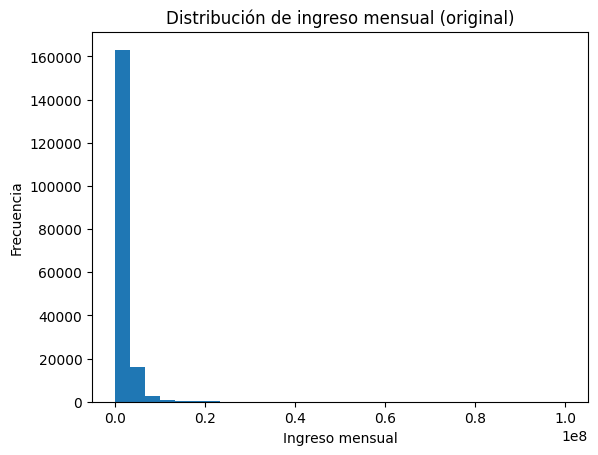

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_anual['ingreso_mensual'].dropna(), bins=30)
plt.title('Distribución de ingreso mensual (original)')
plt.xlabel('Ingreso mensual')
plt.ylabel('Frecuencia')
plt.show()


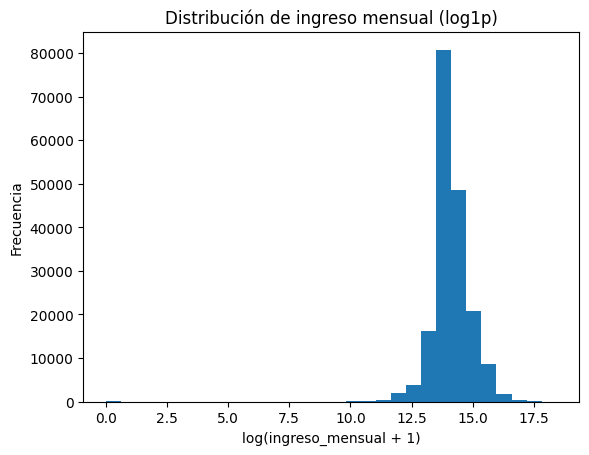

In [ ]:
plt.figure()
plt.hist(df_anual['log_ingreso'].dropna(), bins=30)
plt.title('Distribución de ingreso mensual (log1p)')
plt.xlabel('log(ingreso_mensual + 1)')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
desc2 = df_cont[["ingreso_capped","log_ingreso","edad","antiguedad_empresa_meses"]].describe().T
desc2["skewness"] = df_cont.skew()
desc2["kurtosis"] = df_cont.kurt()
display(desc2)

NameError: name 'df_cont' is not defined

C:\Users\Laura\AppData\Local\Temp\ipykernel_3792\2115068625.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_anual['ingreso_mensual'].dropna(), df_anual['log_ingreso'].dropna()],


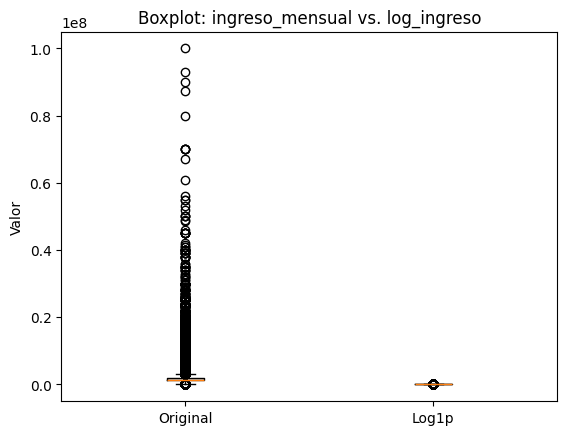

In [ ]:
plt.figure()
plt.boxplot([df_anual['ingreso_mensual'].dropna(), df_anual['log_ingreso'].dropna()],
            labels=['Original', 'Log1p'])
plt.title('Boxplot: ingreso_mensual vs. log_ingreso')
plt.ylabel('Valor')
plt.show()


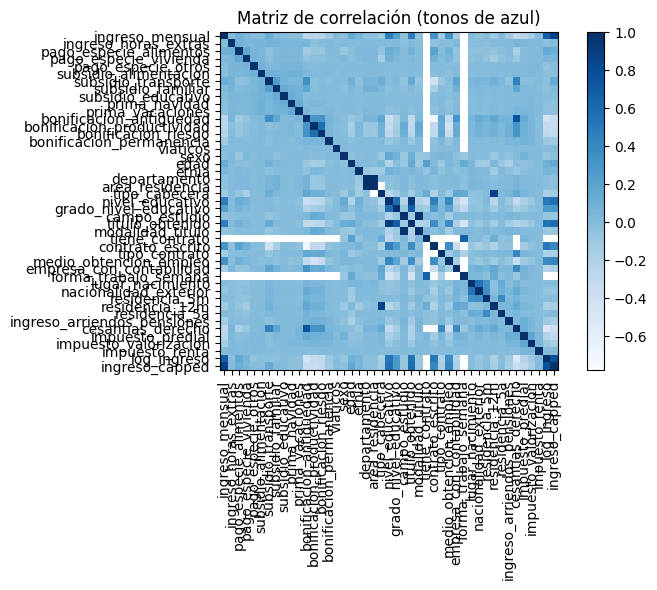

In [ ]:

corr = df_anual.select_dtypes(include=['int64','float64']).corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr, cmap='Blues', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title('Matriz de correlación (tonos de azul)')
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_anual['ingreso_mensual'].quantile(0.25)
Q3 = df_anual['ingreso_mensual'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df_anual[
    (df_anual['ingreso_mensual'] < lower) |
    (df_anual['ingreso_mensual'] > upper)
]
print(f"Número de outliers por IQR: {outliers.shape[0]}")


Número de outliers por IQR: 22677


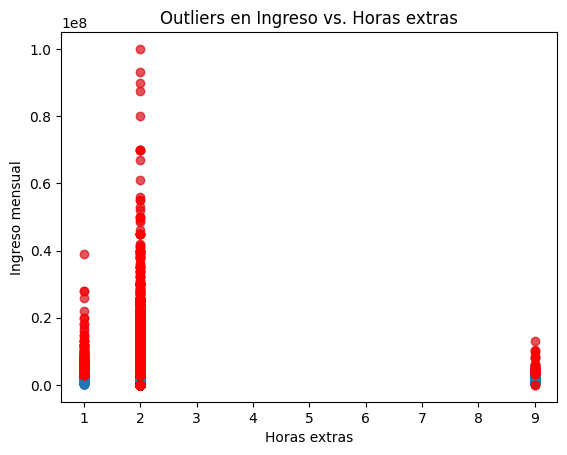

In [ ]:
plt.scatter(df_anual['ingreso_horas_extras'], df_anual['ingreso_mensual'], alpha=0.3)
plt.scatter(outliers['ingreso_horas_extras'], outliers['ingreso_mensual'], color='red', alpha=0.6)
plt.xlabel('Horas extras')
plt.ylabel('Ingreso mensual')
plt.title('Outliers en Ingreso vs. Horas extras')
plt.show()